# Training base expert on vanilla OGBench environment using BC

In [1]:
import random
import torch
import os
import math

import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# num_steps = 1000
# seed = 0
# hidden_dims = set()

# random.seed(seed)
# torch.manual_seed(seed)

In [4]:
# env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)
# train_eps = env.expert.num_eps
# train_eps

In [5]:
# X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
# obs_prefix = env.env.observed_unobserved_vars[0]

In [6]:
# Z_sets = {}
# for Xi in X:
#     i = int(Xi[1:])
#     cond = set()

#     for j in range(i+1):
#         cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

#     for j in range(i):
#         cond.add(f'X{j}')

#     Z_sets[Xi] = cond

In [7]:
# records = collect_expert_trajectories(
#     env,
#     num_episodes=train_eps,
#     max_steps=num_steps,
#     seed=seed
# )

In [8]:
# hidden_size = 256
# lr = 3e-4
# batch_size = 2048
# patience = 15
# lookback = 1
# num_blocks = 4
# epochs = 100
# dropout = 0.0

# dims = {
#     'P': 3,
#     'O': 4,
#     'A': 8,
#     'L': 3,
#     'T': 3,
#     'J': 8,
#     'X': 8
# }

In [9]:
# model, slots, Z_trim = train_single_policy_long_horizon(
#     records,
#     Z_sets,
#     dims=dims,
#     epochs=epochs,
#     include_vars=obs_prefix,
#     lookback=lookback,
#     continuous=True,
#     num_actions = env.action_space.shape[0],
#     hidden_dim=hidden_size,
#     num_blocks=num_blocks,
#     dropout=dropout,
#     lr=lr,
#     batch_size=batch_size,
#     patience=patience,
#     device=device,
#     seed=seed,
#     action_bounds=(env.action_space.low, env.action_space.high)
# )

# policy = shared_policy_fn_long_horizon(model, slots, Z_trim, continuous=True, device=device)
# policies = make_shared_policy_dict(policy)

In [10]:
# expert_episode_rewards = defaultdict(float)
# for rec in records:
#     ep = rec['episode']
#     expert_episode_rewards[ep] += float(rec['reward'])

# num_eps = len(expert_episode_rewards)
# expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

# policy_records = collect_imitator_trajectories(env, policies, num_episodes=num_eps, max_steps=num_steps, seed=seed)
# policy_episode_rewards = defaultdict(float)
# for rec in policy_records:
#     ep = rec['episode']
#     policy_episode_rewards[ep] += float(rec['reward'])

# policy_rewards = [policy_episode_rewards[e] for e in range(num_eps)]
# plt.figure(figsize=(8,5))
# plt.plot(expert_rewards, label='Expert')
# plt.plot(policy_rewards, label='Policy BC')
# plt.xlabel('Episode')
# plt.ylabel('Final Cumulative Reward')
# plt.title('Comparison of Expert Dataset vs. BC Policy Returns')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [11]:
# sum(expert_rewards)/num_eps, sum(policy_rewards)/num_eps

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

In [13]:
# fig, ax = plot_ant_trajectory_xy(records, episode_id=0, title_prefix='Expert AntMaze')
# plt.show()

In [14]:
# fig, ax = plot_ant_trajectory_xy(policy_records, episode_id=np.random.randint(0, 1102), title_prefix='Naive AntMaze')
# plt.show()

In [15]:
# # save model for fine-tuning
# import os
# import torch

# SAVE_DIR = '/home/et2842/causal/causalrl/models'
# os.makedirs(SAVE_DIR, exist_ok=True)
# MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_expert.pt')

# checkpoint = {
#     "state_dict": model.state_dict(),
#     "slots": slots,
#     "Z_trim": Z_trim,
#     "dims": dims,
#     "lookback": lookback,
#     "continuous": True,
#     "num_actions": env.action_space.shape[0],
#     "hidden_dim": hidden_size,
#     "num_blocks": num_blocks,
#     "dropout": 0.0,
#     "layernorm": True,
#     "final_tanh": True,
#     "action_bounds_low": env.action_space.low,
#     "action_bounds_high": env.action_space.high,
#     "input_dim": int(model.hidden.in_features),
# }

# torch.save(checkpoint, MODEL_PATH)
# print("Saved expert to:", MODEL_PATH)

In [16]:
# load model
MODEL_PATH = "/home/et2842/causal/causalrl/models/antmaze_expert.pt"
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

pretrained_actor = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

pretrained_actor.load_state_dict(checkpoint['state_dict'])
# pretrained_actor.eval()
pretrained_actor.train()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

/tmp/ipykernel_2713819/3540482843.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


44

In [17]:
num_steps = 1000
rl_seed_pretrain = 2014
rl_seed = 90210
hidden_dims = set() # {'W'}

env_pretrain = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=rl_seed_pretrain)
env_train = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=rl_seed)
action_dim = env_train.env.action_space.shape[0]
action_dim

8

In [18]:
# reward shaping
def make_dense_distance_reward(env, use_delta=True, c=1.0):
        goal_xy = env.env._goal_xy
    
        def reward_fn(obs, reward_env):
            t = len(obs['P']) - 1
    
            P_curr = obs['P'][t]
            curr_xy = np.array(P_curr[:2], dtype=np.float64)
            dist_curr = np.linalg.norm(curr_xy - goal_xy)
    
            if use_delta:
                if t == 0:
                    return 0.0
                P_prev = obs['P'][t - 1]
                prev_xy = np.array(P_prev[:2], dtype=np.float64)
                dist_prev = np.linalg.norm(prev_xy - goal_xy)
                return float(c * (dist_prev - dist_curr))
            else:
                return float(-c * dist_curr)
    
        return reward_fn

reward_fn = make_dense_distance_reward(env_train)

In [19]:
config = OnlineRLConfig(
    total_env_steps=200_000,
    start_steps=10_000,
    max_episode_steps=num_steps,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    policy_delay=2,
    actor_lr=3e-6,
    critic_lr=3e-4,
    noise_std=0.05,
    hidden_dim_q=256,
    target_policy_noise=0.1,
    target_noise_clip=0.2,
    actor_warmup_steps=30_000,
    bc_reg_lambda=0.1,
    max_grad_norm=1.0
)

In [20]:
# pretrain critics offline
replay_buffer, q1, q2, target_q1, target_q2 = pretrain_critics_offline(
    env=env_pretrain,
    pretrained_actor=pretrained_actor,
    Z_trim=Z_trim,
    slots=slots,
    state_dim=state_dim,
    action_dim=action_dim,
    config=config,
    device=device,
    num_pretrain_steps=100_000,
    pretrain_updates=50_000,
    seed=rl_seed_pretrain,
    reward_shaping_fn=reward_fn
)

In [21]:
def callback(stats: dict):
    if stats['episode'] % 1 == 0:
        print(
            f'[Episode {stats["episode"]}] '
            f'steps={stats["env_steps"]}, '
            f'return={stats["return"]:.2f}, '
            f'len={stats["length"]}, '
            f'buffer={stats["buffer_size"]}'
        )

In [ ]:
fine_tuned_policy, logs = td3_fine_tune_actor(
    env=env_train,
    actor=pretrained_actor,
    Z_trim=Z_trim,
    slots=slots,
    state_dim=state_dim,
    action_dim=action_dim,
    config=config,
    device=device,
    seed=rl_seed,
    log_callback=callback,
    replay_buffer=replay_buffer,
    initial_q1=q1,
    initial_q2=q2,
    initial_target_q1=target_q1,
    initial_target_q2=target_q2,
    reward_shaping_fn=reward_fn
)

ft_pi = shared_policy_fn_long_horizon(fine_tuned_policy, slots, Z_trim, continuous=True, device=device)
ft_policies = make_shared_policy_dict(ft_pi)

[Episode 1] steps=1000, return=11.57, len=1000, buffer=101528
[Episode 2] steps=2000, return=11.00, len=1000, buffer=102528
[Episode 3] steps=3000, return=10.09, len=1000, buffer=103528
[Episode 4] steps=4000, return=5.98, len=1000, buffer=104528
[Episode 5] steps=5000, return=14.21, len=1000, buffer=105528
[Episode 6] steps=6000, return=8.47, len=1000, buffer=106528
[Episode 7] steps=7000, return=0.02, len=1000, buffer=107528
[Episode 8] steps=8000, return=11.40, len=1000, buffer=108528
[Episode 9] steps=9000, return=10.23, len=1000, buffer=109528
[Episode 10] steps=10000, return=12.52, len=1000, buffer=110528
[Episode 11] steps=11000, return=-1.95, len=1000, buffer=111528
[Episode 12] steps=12000, return=13.36, len=1000, buffer=112528
[Episode 13] steps=13000, return=4.10, len=1000, buffer=113528
[Episode 14] steps=14000, return=-0.20, len=1000, buffer=114528
[Episode 15] steps=15000, return=2.10, len=1000, buffer=115528
[Episode 16] steps=16000, return=13.22, len=1000, buffer=116528

In [ ]:
# # save expert
import os
import torch

SAVE_DIR = '/home/et2842/causal/causalrl/models'
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_expert_finetuned.pt')

checkpoint = {
    "state_dict": fine_tuned_policy.state_dict(),
    "slots": slots,
    "Z_trim": Z_trim,
    "dims": dims,
    "lookback": lookback,
    "continuous": True,
    "num_actions": env_train.action_space.shape[0],
    "hidden_dim": config.hidden_dim_q,
    "num_blocks": checkpoint['num_blocks'],
    "dropout": 0.0,
    "layernorm": True,
    "final_tanh": True,
    "action_bounds_low": env_train.action_space.low,
    "action_bounds_high": env_train.action_space.high,
    "input_dim": int(fine_tuned_policy.hidden.in_features),
}

torch.save(checkpoint, MODEL_PATH)
print("Saved expert to:", MODEL_PATH)

Saved expert to: /home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt


In [ ]:
# load fine tuned model
MODEL_PATH = "/home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt"
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

finetuned_actor = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

finetuned_actor.load_state_dict(checkpoint['state_dict'])
finetuned_actor.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

ft_policy = shared_policy_fn_long_horizon(finetuned_actor, slots, Z_trim, continuous=True, device=device)
ft_policies = make_shared_policy_dict(ft_policy)

/tmp/ipykernel_2017083/1741894977.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


In [ ]:
num_eval_eps = 10
env_eval = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims)
ft_records = collect_imitator_trajectories(
    env_eval,
    ft_policies,
    num_episodes=num_eval_eps,
    max_steps=num_steps,
    seed=rl_seed + 1,
    show_progress=True
)

len(ft_records)

Starting episode 1/10...
  Episode 1 ended at step 295 (terminated: True, truncated: False).
Starting episode 2/10...
  Episode 2 ended at step 266 (terminated: True, truncated: False).
Starting episode 3/10...
  Episode 3 ended at step 286 (terminated: True, truncated: False).
Starting episode 4/10...
  Episode 4 ended at step 205 (terminated: True, truncated: False).
Starting episode 5/10...
  Episode 5 ended at step 209 (terminated: True, truncated: False).
Starting episode 6/10...
  Episode 6 ended at step 251 (terminated: True, truncated: False).
Starting episode 7/10...
  Episode 7 ended at step 221 (terminated: True, truncated: False).
Starting episode 8/10...
  Episode 8 ended at step 188 (terminated: True, truncated: False).
Starting episode 9/10...


  Episode 9 ended at step 247 (terminated: True, truncated: False).
Starting episode 10/10...
  Episode 10 ended at step 248 (terminated: True, truncated: False).
Finished collecting imitator trajectories.


2416

In [ ]:
ft_episode_returns = defaultdict(float)
for r in ft_records:
    ep = r['episode']
    ft_episode_returns[ep] += float(r['reward'])

ft_returns = [ft_episode_returns[e] for e in range(num_eval_eps)]
ft_returns

[-354.8074344128937,
 -311.1696191531063,
 -365.475406125529,
 -279.0895929190133,
 -287.96281598217877,
 -310.4911380552356,
 -263.5750474372792,
 -235.21914297257933,
 -319.8510993477776,
 -305.0363596223268]

In [ ]:
# plot learning curves
plt.figure(figsize=(8,4))
plt.plot(logs['episode_returns'])
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('TD3 Fine-tuning: Episode returns over time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
i = 0

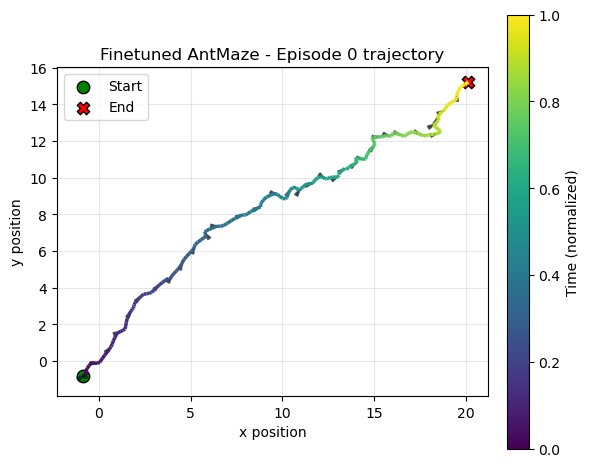

In [ ]:
fig, ax = plot_ant_trajectory_xy(ft_records, episode_id=i % 10, title_prefix='Finetuned AntMaze')
plt.show()
i += 1

No clear give-up point detected under current thresholds.


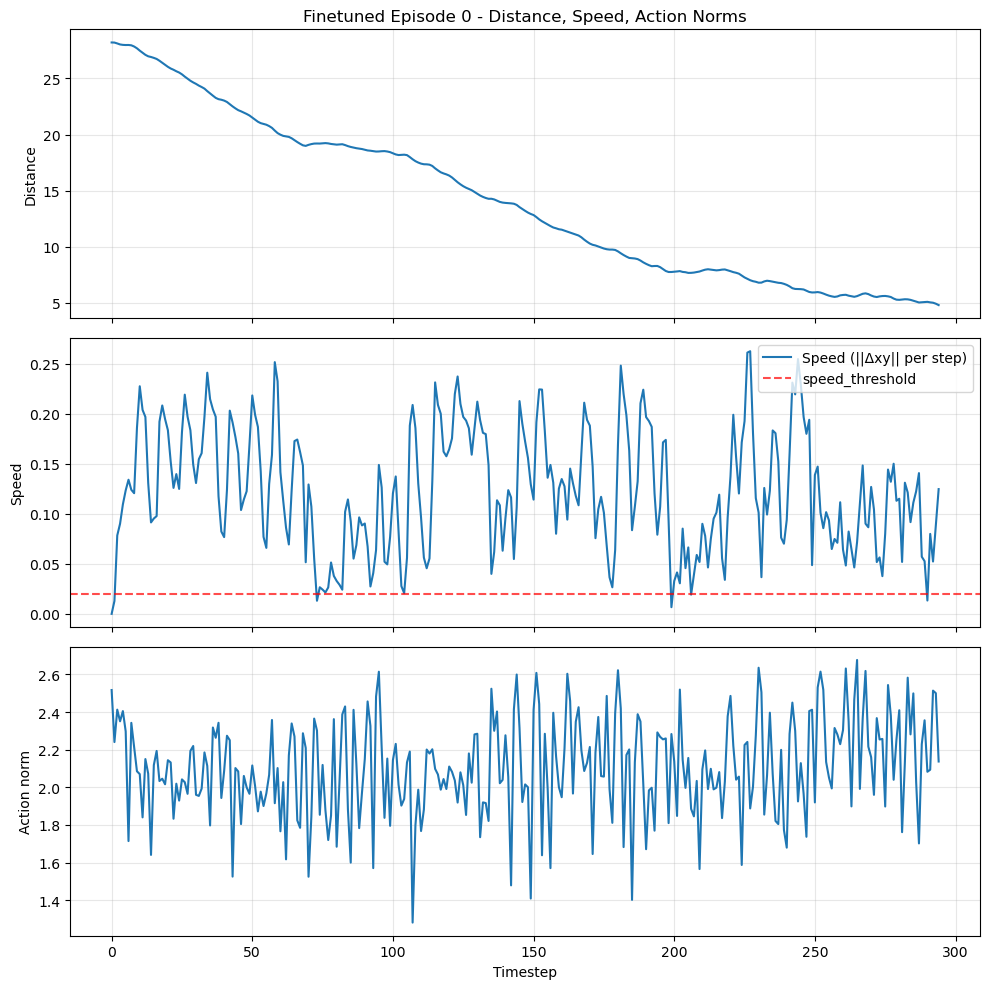

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_ft_episode_giveup(records, episode_id=0, speed_threshold=0.02, tail_fraction=0.3):
    """
    Analyze one episode from ft_records and visualize when the policy 'gives up'.

    Args:
        records: list of dicts from collect_imitator_trajectories(...)
        episode_id: which episode to analyze
        speed_threshold: threshold on ||Δpos|| to consider 'not moving' between steps
        tail_fraction: fraction of the episode tail that must be 'slow' to count as giving up
    """
    # Filter and sort records for this episode
    ep = [r for r in records if r['episode'] == episode_id]
    if len(ep) == 0:
        print(f"No records found for episode {episode_id}")
        return
    
    ep = sorted(ep, key=lambda r: r['step'])
    T = len(ep)
    timesteps = np.arange(T)

    # Extract positions, rewards, actions
    xs, ys = [], []
    rewards = []
    action_norms = []
    for r in ep:
        pos = r['obs']['P'][-1]     # (3,) current position
        xs.append(pos[0])
        ys.append(pos[1])
        rewards.append(r['reward'])

        if 'X' in r['obs'] and len(r['obs']['X']) > 0:
            action = r['obs']['X'][-1]
            action_norms.append(float(np.linalg.norm(action)))
        else:
            action_norms.append(np.nan)

    xs = np.array(xs)
    ys = np.array(ys)
    rewards = np.array(rewards)
    action_norms = np.array(action_norms)

    # Goal position (if available from env_info)
    goal_xy = None
    if 'env_info' in ep[0]['info'] and 'goal' in ep[0]['info']['env_info']:
        goal_xy = np.asarray(ep[0]['info']['env_info']['goal'][:2], dtype=np.float64)
    else:
        # Fall back to default or print a warning
        print("Warning: goal not found in env_info; using (20,20) as default")
        goal_xy = np.array([20.0, 20.0], dtype=np.float64)

    # Distance to goal over time
    pos_xy = np.stack([xs, ys], axis=-1)
    dists = np.linalg.norm(pos_xy - goal_xy, axis=-1)

    # Step-to-step translational speed in XY
    # speed[t] = ||pos[t] - pos[t-1]||, speed[0] = 0
    deltas = pos_xy[1:] - pos_xy[:-1]
    speeds = np.zeros(T)
    speeds[1:] = np.linalg.norm(deltas, axis=-1)

    # Cumulative return (for visual correlation)
    cum_returns = np.cumsum(rewards)

    # --- Detect "give up" point ---
    # We say the policy has 'given up' if, after some step t*, the speed stays
    # below speed_threshold for at least tail_fraction of the episode.
    tail_len = int(T * tail_fraction)
    giveup_step = None

    if tail_len > 0:
        for t in range(T - tail_len):
            tail_speeds = speeds[t:]
            if np.all(tail_speeds < speed_threshold):
                giveup_step = t
                break

    # --- Plotting ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # 1) Distance to goal
    axes[0].plot(timesteps, dists, label='Distance to goal')
    axes[0].set_ylabel('Distance')
    axes[0].set_title(f'Finetuned Episode {episode_id} - Distance, Speed, Action Norms')
    axes[0].grid(alpha=0.3)

    # 2) Speed
    axes[1].plot(timesteps, speeds, label='Speed (||Δxy|| per step)')
    axes[1].axhline(speed_threshold, color='r', linestyle='--', alpha=0.7, label='speed_threshold')
    axes[1].set_ylabel('Speed')
    axes[1].grid(alpha=0.3)
    axes[1].legend(loc='upper right')

    # 3) Action norm
    axes[2].plot(timesteps, action_norms, label='||action||')
    axes[2].set_ylabel('Action norm')
    axes[2].set_xlabel('Timestep')
    axes[2].grid(alpha=0.3)

    # Mark give-up step if found
    if giveup_step is not None:
        for ax in axes:
            ax.axvline(giveup_step, color='orange', linestyle='--', alpha=0.8)
        axes[0].text(
            giveup_step, dists[giveup_step],
            '  give up?',
            color='orange',
            va='bottom',
            ha='left',
        )
        print(f"Detected potential give-up step at t = {giveup_step}")
    else:
        print("No clear give-up point detected under current thresholds.")

    plt.tight_layout()
    plt.show()

# Example usage:
analyze_ft_episode_giveup(ft_records, episode_id=0, speed_threshold=0.02, tail_fraction=0.3)

P mean: [7.14272272 6.56979802 0.54436688]
L mean: [ 0.86228191  0.6866467  -0.02038422]
O mean: [ 0.90444358  0.05441375 -0.03124435 -0.20634912]
A mean: [ 0.385734    0.78828058  0.02352896 -0.73160069  0.01138437 -0.54866389
 -0.10106051  0.63577672]
T mean: [ 0.00924791 -0.01937524 -0.04504448]
J mean: [ 0.01351685  0.02412029 -0.00224421 -0.04531884  0.01878388 -0.0367807
 -0.00767139  0.05793452]

=== Graph-aware sensitivity to P ===
Used 2406 samples for P.
Mean ||Δaction||:    0.6770
Median ||Δaction||:  0.5995
Max ||Δaction||:     2.7506
Mean cos-sim:        0.9250


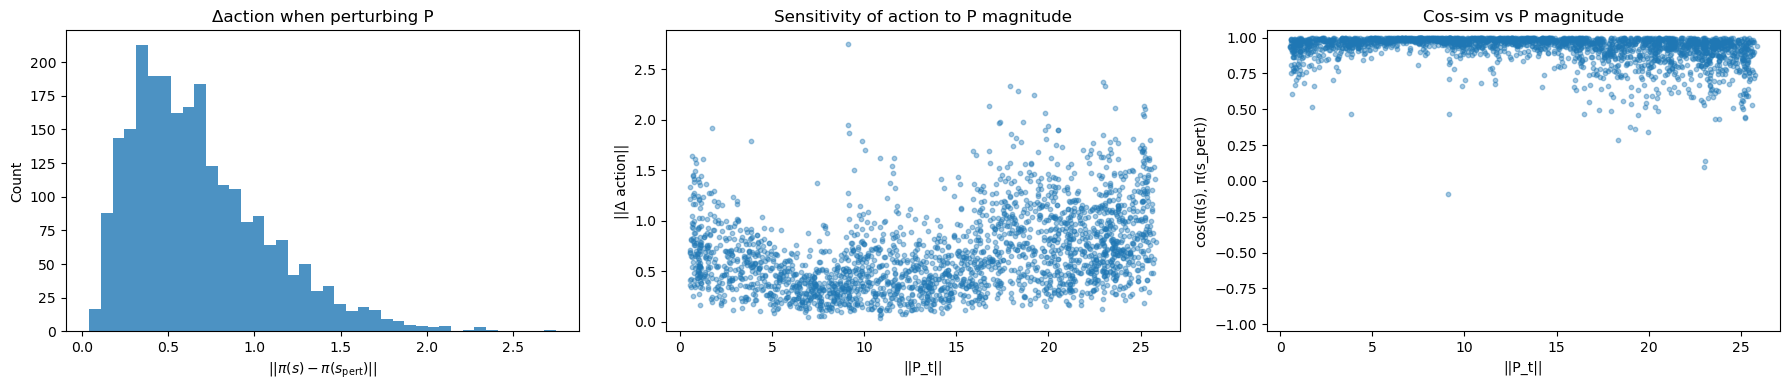


=== Graph-aware sensitivity to L ===
Used 2406 samples for L.
Mean ||Δaction||:    0.3570
Median ||Δaction||:  0.3094
Max ||Δaction||:     1.9615
Mean cos-sim:        0.9771


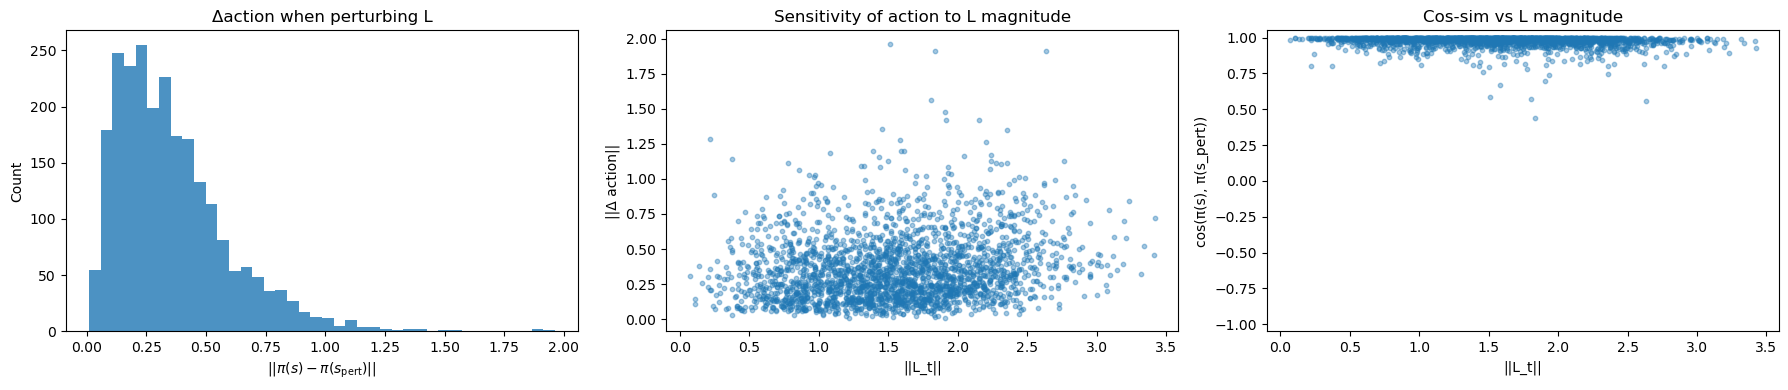


=== Graph-aware sensitivity to O ===


Used 2406 samples for O.
Mean ||Δaction||:    0.8228
Median ||Δaction||:  0.5815
Max ||Δaction||:     3.6299
Mean cos-sim:        0.8643


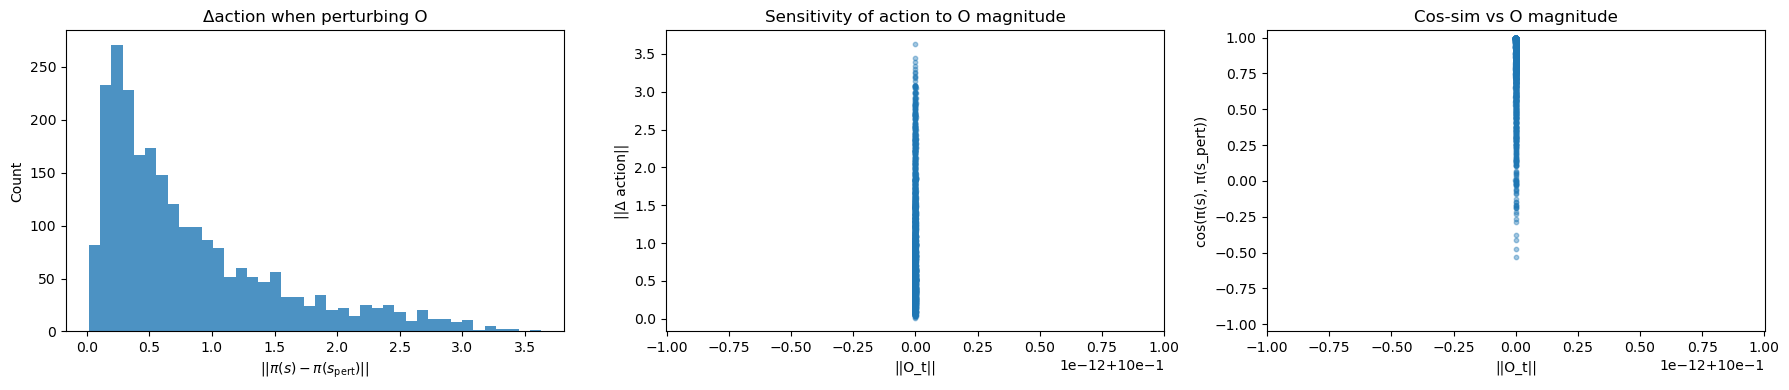


=== Graph-aware sensitivity to A ===
Used 2406 samples for A.
Mean ||Δaction||:    1.1123
Median ||Δaction||:  0.9912
Max ||Δaction||:     3.4578
Mean cos-sim:        0.8030


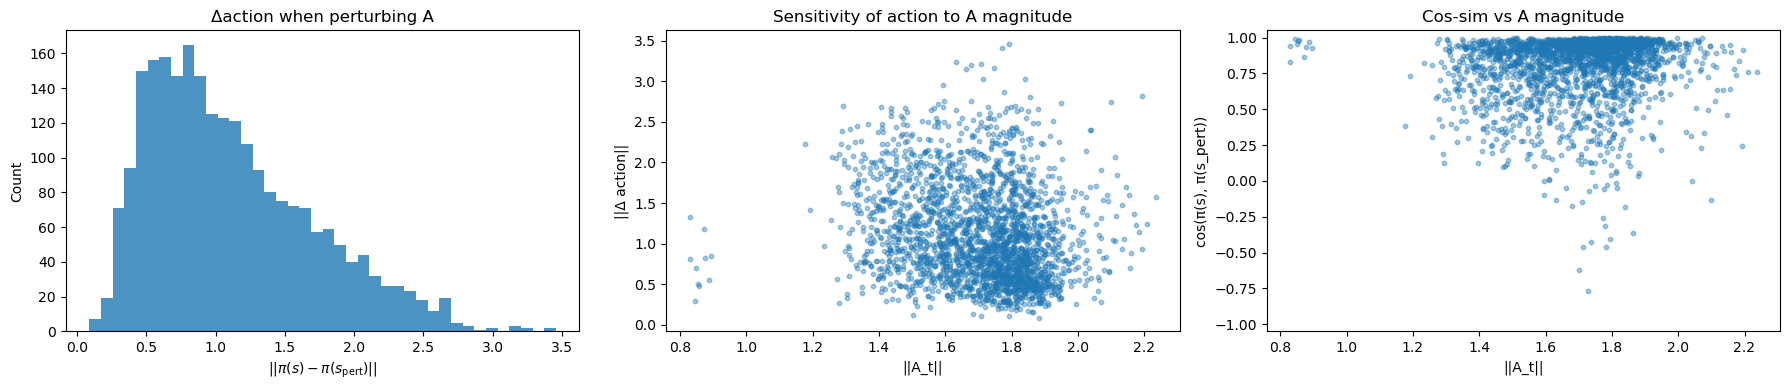


=== Graph-aware sensitivity to T ===
Used 2406 samples for T.
Mean ||Δaction||:    0.3689
Median ||Δaction||:  0.3058
Max ||Δaction||:     2.9395
Mean cos-sim:        0.9753


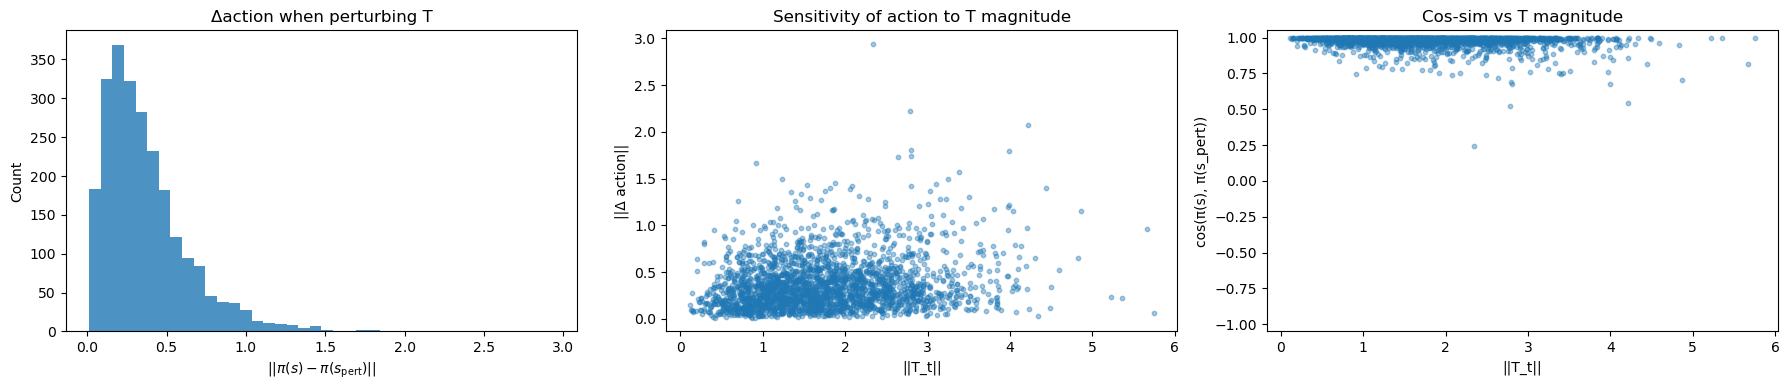


=== Graph-aware sensitivity to J ===
Used 2406 samples for J.
Mean ||Δaction||:    0.9837
Median ||Δaction||:  0.8688
Max ||Δaction||:     3.3726
Mean cos-sim:        0.8349


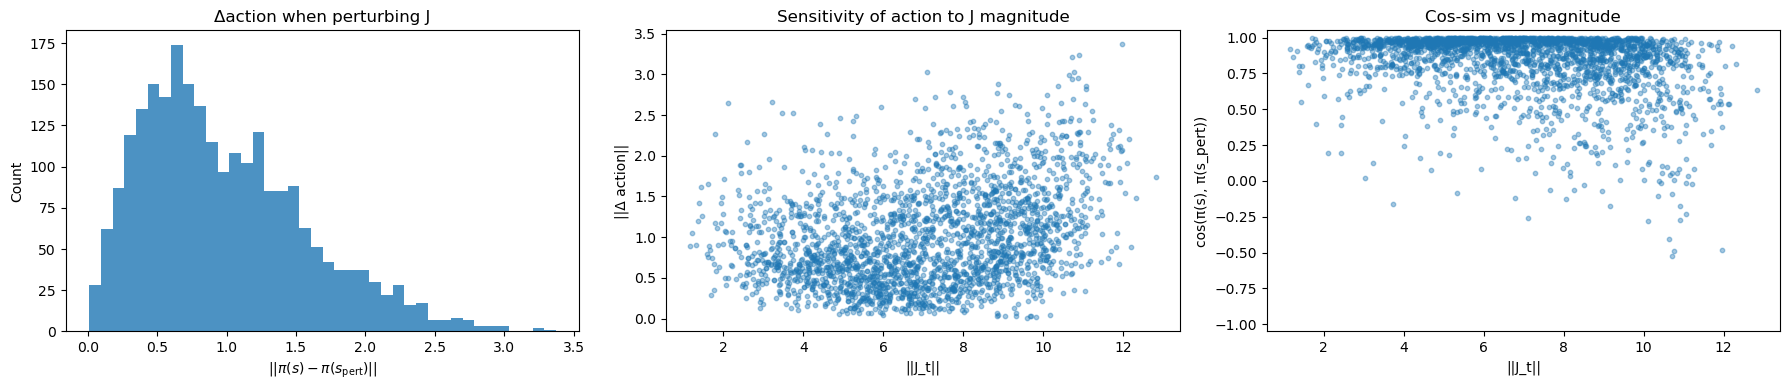

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Graph- and window-aware sensitivity analysis for P, L, O, A, T, J
# -------------------------------------------------------------------

def compute_var_means(records, var_names):
    """
    Compute global means for each var in var_names over *all timesteps*
    in full_records. This is used as the 'neutral' replacement value.
    """
    sums = {v: None for v in var_names}
    counts = {v: 0 for v in var_names}

    for r in records:
        obs = r['obs']
        for v in var_names:
            if v not in obs:
                continue
            for val in obs[v]:
                arr = np.asarray(val, dtype=np.float64)
                if sums[v] is None:
                    sums[v] = np.zeros_like(arr)
                sums[v] += arr
                counts[v] += 1

    means = {}
    for v in var_names:
        if counts[v] == 0 or sums[v] is None:
            print(f"[WARN] No data for var {v} when computing global means.")
            continue
        means[v] = sums[v] / counts[v]
        print(f"{v} mean:", means[v])

    return means


def analyze_sensitivity_to_var_graph_aware(
    var_name: str,
    records,
    actor,
    Z_trim,
    slots,
    device,
    lookback: int = 1,
    max_samples: int = 5000,
    var_means: dict[str, np.ndarray] | None = None,
):
    """
    Measure how sensitive the expert's actions are to SCM variable `var_name`
    (one of 'P','L','O','A','T','J'), *taking into account* the actual Z_trim
    and window structure.

    For each sample (obs_t, a_t) at time t:
      1) Build state_full from obs using build_state_feature(...).
      2) Construct obs_pert by replacing obs[var_name][step] with the
         global mean for all (var_name, step) that appear in Z_trim[X_t].
      3) Build state_pert from obs_pert.
      4) Compare a_full = π(state_full) vs a_pert = π(state_pert).
      5) Record:
           - ||v_t||  (norm of the *current* value of var_name at time t, if present)
           - ||Δa||   (action L2 difference)
           - cos_sim  (cosine similarity of actions).
    """

    print(f"\n=== Graph-aware sensitivity to {var_name} ===")

    if var_means is None or var_name not in var_means:
        print(f"[WARN] No mean provided for {var_name}; aborting.")
        return

    all_var_norms = []
    all_deltas = []
    all_cos_sims = []

    input_dim = actor.hidden.in_features
    actor.eval()

    sample_count = 0

    with torch.no_grad():
        for r in records:
            if sample_count >= max_samples:
                break

            t = int(r['step'])
            if t < lookback:
                continue  # not enough history for window

            obs = r['obs']

            # Build original state
            state_full = build_state_feature(
                obs,
                t,
                Z_trim,
                slots,
                device
            )
            if state_full.shape[1] != input_dim:
                continue  # skip inconsistent samples

            # Determine which (var, step) pairs matter at this time t
            key = f'X{t}'
            Zt = Z_trim.get(key, set())
            if len(Zt) == 0:
                continue

            # Z_idx uses absolute timesteps, same as build_window_features
            Z_idx = {(v[0], int(v[1:])) for v in Zt}

            # Deep copy obs to perturb only this sample
            obs_pert = {}
            for k, hist in obs.items():
                if isinstance(hist, list):
                    obs_pert[k] = [np.array(h, copy=True) for h in hist]
                else:
                    obs_pert[k] = hist

            # For each (var_name, step) used in Z_trim[X_t], replace that obs entry
            mean_v = var_means[var_name]
            for (v, step_idx) in Z_idx:
                if v != var_name:
                    continue
                if v not in obs_pert:
                    continue
                if step_idx < 0 or step_idx >= len(obs_pert[v]):
                    continue
                obs_pert[v][step_idx] = np.array(mean_v, dtype=np.float64)

            # Build perturbed state
            state_pert = build_state_feature(
                obs_pert,
                t,
                Z_trim,
                slots,
                device
            )
            if state_pert.shape[1] != input_dim:
                continue

            # Get actions
            a_full = actor(state_full).cpu().numpy().reshape(-1)
            a_pert = actor(state_pert).cpu().numpy().reshape(-1)

            # If there is no var_name at time t, we still record Δa,
            # but var_norm will be 0.
            if var_name in obs and len(obs[var_name]) > t:
                v_t = np.asarray(obs[var_name][t], dtype=np.float64)
                var_norm = np.linalg.norm(v_t)
            else:
                var_norm = 0.0

            delta = np.linalg.norm(a_full - a_pert)

            denom = (np.linalg.norm(a_full) * np.linalg.norm(a_pert) + 1e-8)
            cos_sim = float(np.dot(a_full, a_pert) / denom)

            all_var_norms.append(var_norm)
            all_deltas.append(delta)
            all_cos_sims.append(cos_sim)

            sample_count += 1

    all_var_norms = np.array(all_var_norms)
    all_deltas = np.array(all_deltas)
    all_cos_sims = np.array(all_cos_sims)

    print(f"Used {len(all_deltas)} samples for {var_name}.")
    if len(all_deltas) == 0:
        print("No valid samples; aborting plots.")
        return

    print(f"Mean ||Δaction||:    {all_deltas.mean():.4f}")
    print(f"Median ||Δaction||:  {np.median(all_deltas):.4f}")
    print(f"Max ||Δaction||:     {all_deltas.max():.4f}")
    print(f"Mean cos-sim:        {all_cos_sims.mean():.4f}")

    # ----------------- plots -----------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # (a) histogram of action change
    axes[0].hist(all_deltas, bins=40, alpha=0.8)
    axes[0].set_xlabel(r'||$\pi(s) - \pi(s_{\mathrm{pert}})$||')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Δaction when perturbing {var_name}')

    # (b) scatter of ||var|| vs ||Δaction||
    axes[1].scatter(all_var_norms, all_deltas, alpha=0.4, s=10)
    axes[1].set_xlabel(rf'||{var_name}_t||')
    axes[1].set_ylabel(r'||Δ action||')
    axes[1].set_title(rf'Sensitivity of action to {var_name} magnitude')

    # (c) cos-sim vs ||var||
    axes[2].scatter(all_var_norms, all_cos_sims, alpha=0.4, s=10)
    axes[2].set_xlabel(rf'||{var_name}_t||')
    axes[2].set_ylabel('cos(π(s), π(s_pert))')
    axes[2].set_ylim(-1.05, 1.05)
    axes[2].set_title(rf'Cos-sim vs {var_name} magnitude')

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# Run analysis for P, L, O, A, T, J
# ------------------------------------------------------------

candidate_vars = ['P', 'L', 'O', 'A', 'T', 'J']

var_means = compute_var_means(ft_records, candidate_vars)

for v in candidate_vars:
    analyze_sensitivity_to_var_graph_aware(
        var_name=v,
        records=ft_records,
        actor=finetuned_actor,
        Z_trim=Z_trim,
        slots=slots,
        device=device,
        lookback=lookback,
        max_samples=5000,
        var_means=var_means
    )

Starting episode 1/100...
  Episode 1 ended at step 207 (terminated: True, truncated: False).
Starting episode 2/100...
  Episode 2 ended at step 244 (terminated: True, truncated: False).
Starting episode 3/100...
  Episode 3 ended at step 241 (terminated: True, truncated: False).
Starting episode 4/100...
  Episode 4 ended at step 278 (terminated: True, truncated: False).
Starting episode 5/100...
  Episode 5 ended at step 246 (terminated: True, truncated: False).
Starting episode 6/100...
  Episode 6 ended at step 237 (terminated: True, truncated: False).
Starting episode 7/100...
  Episode 7 ended at step 271 (terminated: True, truncated: False).
Starting episode 8/100...
  Episode 8 ended at step 230 (terminated: True, truncated: False).
Starting episode 9/100...
  Episode 9 ended at step 218 (terminated: True, truncated: False).
Starting episode 10/100...
  Episode 10 ended at step 235 (terminated: True, truncated: False).
Starting episode 11/100...
  Episode 11 ended at step 225 

  Episode 17 ended at step 255 (terminated: True, truncated: False).
Starting episode 18/100...
  Episode 18 ended at step 268 (terminated: True, truncated: False).
Starting episode 19/100...
  Episode 19 ended at step 236 (terminated: True, truncated: False).
Starting episode 20/100...
  Episode 20 ended at step 307 (terminated: True, truncated: False).
Starting episode 21/100...
  Episode 21 ended at step 228 (terminated: True, truncated: False).
Starting episode 22/100...
  Episode 22 ended at step 234 (terminated: True, truncated: False).
Starting episode 23/100...
  Episode 23 ended at step 287 (terminated: True, truncated: False).
Starting episode 24/100...
  Episode 24 ended at step 173 (terminated: True, truncated: False).
Starting episode 25/100...
  Episode 25 ended at step 257 (terminated: True, truncated: False).
Starting episode 26/100...
  Episode 26 ended at step 257 (terminated: True, truncated: False).
Starting episode 27/100...
  Episode 27 ended at step 245 (terminat

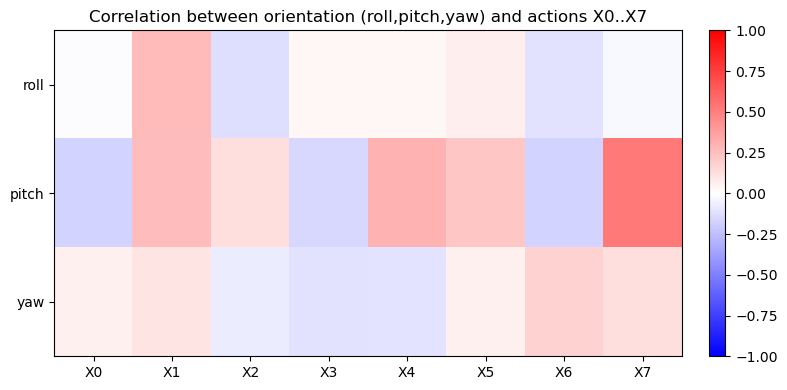

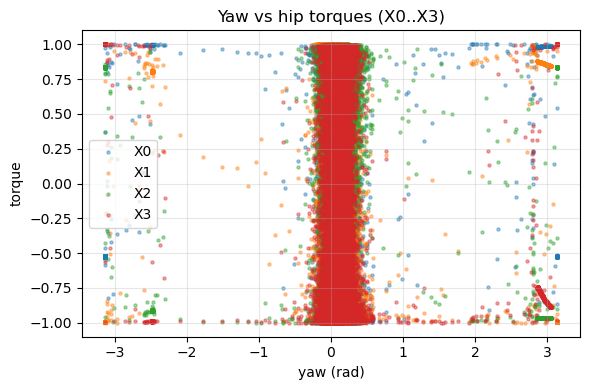

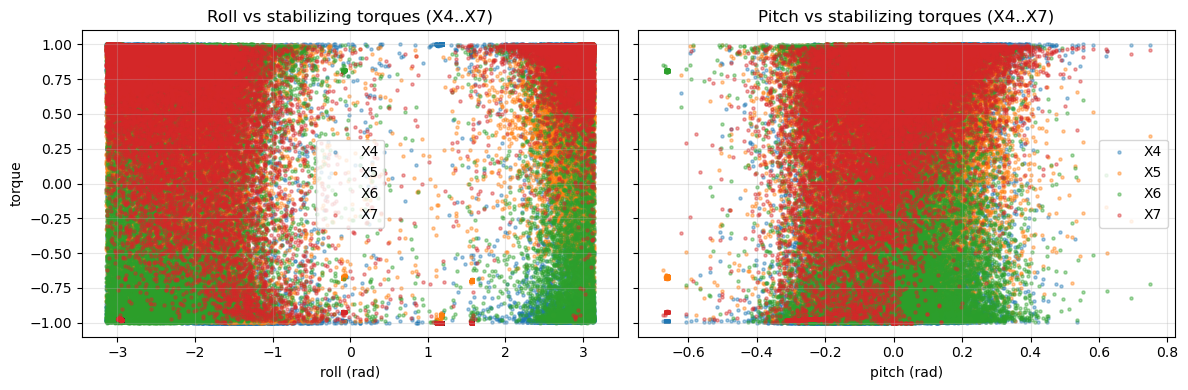

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------- helper: quaternion (x,y,z,w) -> roll, pitch, yaw --------
def quat_to_euler(qx, qy, qz, qw):
    """
    Convert MuJoCo-style quaternion (x,y,z,w) to roll, pitch, yaw (radians).
    Assumes right-handed coordinates.
    """
    # roll (x-axis rotation)
    sinr_cosp = 2.0 * (qw * qx + qy * qz)
    cosr_cosp = 1.0 - 2.0 * (qx * qx + qy * qy)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # pitch (y-axis rotation)
    sinp = 2.0 * (qw * qy - qz * qx)
    if abs(sinp) >= 1:
        pitch = np.sign(sinp) * (np.pi / 2.0)  # use 90° if out of range
    else:
        pitch = np.arcsin(sinp)

    # yaw (z-axis rotation)
    siny_cosp = 2.0 * (qw * qz + qx * qy)
    cosy_cosp = 1.0 - 2.0 * (qy * qy + qz * qz)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

# -------- collect (roll, pitch, yaw, X) pairs from expert trajectories --------
rolls = []
pitches = []
yaws = []
actions = []  # will be N x 8

full_records = collect_imitator_trajectories(
    env_eval,
    ft_policies,
    num_episodes=100,
    max_steps=num_steps,
    seed=rl_seed + 1009,
    show_progress=True
)

for r in full_records:
    obs = r['obs']
    # current orientation and action = last entries in their histories
    O_t = np.asarray(obs['O'][-1], dtype=np.float64)  # [qx,qy,qz,qw]
    X_t = np.asarray(obs['X'][-1], dtype=np.float64)  # shape (8,)

    qx, qy, qz, qw = O_t
    roll, pitch, yaw = quat_to_euler(qx, qy, qz, qw)

    rolls.append(roll)
    pitches.append(pitch)
    yaws.append(yaw)
    actions.append(X_t)

rolls = np.array(rolls)
pitches = np.array(pitches)
yaws = np.array(yaws)
actions = np.stack(actions, axis=0)  # (N, 8)

print("Collected", actions.shape[0], "samples for O->X analysis.")

# -------- correlation: [roll, pitch, yaw] vs X0..X7 --------
# Build matrix (11 x N): [roll, pitch, yaw, X0..X7]
A = np.vstack([rolls, pitches, yaws, actions.T])  # shape (11, N)
corr = np.corrcoef(A)  # (11 x 11)

# Extract 3x8 block: rows roll/pitch/yaw, cols X0..X7
corr_rpy_X = corr[0:3, 3:11]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
im = ax.imshow(corr_rpy_X, cmap='bwr', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(8))
ax.set_xticklabels([f'X{i}' for i in range(8)])
ax.set_yticks(range(3))
ax.set_yticklabels(['roll', 'pitch', 'yaw'])
ax.set_title('Correlation between orientation (roll,pitch,yaw) and actions X0..X7')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# -------- scatter plots for more detailed structure --------
# 1) yaw vs hip torques X0..X3
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(4):
    ax.scatter(yaws, actions[:, i], s=5, alpha=0.4, label=f'X{i}')
ax.set_xlabel('yaw (rad)')
ax.set_ylabel('torque')
ax.set_title('Yaw vs hip torques (X0..X3)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) roll vs X4..X7, pitch vs X4..X7
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i in range(4, 8):
    axes[0].scatter(rolls, actions[:, i], s=5, alpha=0.4, label=f'X{i}')
axes[0].set_xlabel('roll (rad)')
axes[0].set_ylabel('torque')
axes[0].set_title('Roll vs stabilizing torques (X4..X7)')
axes[0].legend()
axes[0].grid(alpha=0.3)

for i in range(4, 8):
    axes[1].scatter(pitches, actions[:, i], s=5, alpha=0.4, label=f'X{i}')
axes[1].set_xlabel('pitch (rad)')
axes[1].set_title('Pitch vs stabilizing torques (X4..X7)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Dataset sizes: (27528, 4) (27528, 8)
Epoch   1 | train MSE: 0.4306 | val MSE: 0.3856
Epoch   5 | train MSE: 0.3554 | val MSE: 0.3641
Epoch  10 | train MSE: 0.3455 | val MSE: 0.3511
Epoch  15 | train MSE: 0.3401 | val MSE: 0.3458
Epoch  20 | train MSE: 0.3368 | val MSE: 0.3440
Epoch  25 | train MSE: 0.3334 | val MSE: 0.3407
Epoch  30 | train MSE: 0.3317 | val MSE: 0.3361
Epoch  35 | train MSE: 0.3287 | val MSE: 0.3336
Epoch  40 | train MSE: 0.3289 | val MSE: 0.3321
Epoch  45 | train MSE: 0.3250 | val MSE: 0.3316
Epoch  50 | train MSE: 0.3248 | val MSE: 0.3297
Per-dimension corr(X_i, h(O)_i):
  dim 0: 0.544
  dim 1: 0.793
  dim 2: 0.714
  dim 3: 0.487
  dim 4: 0.516
  dim 5: 0.594
  dim 6: 0.571
  dim 7: 0.848


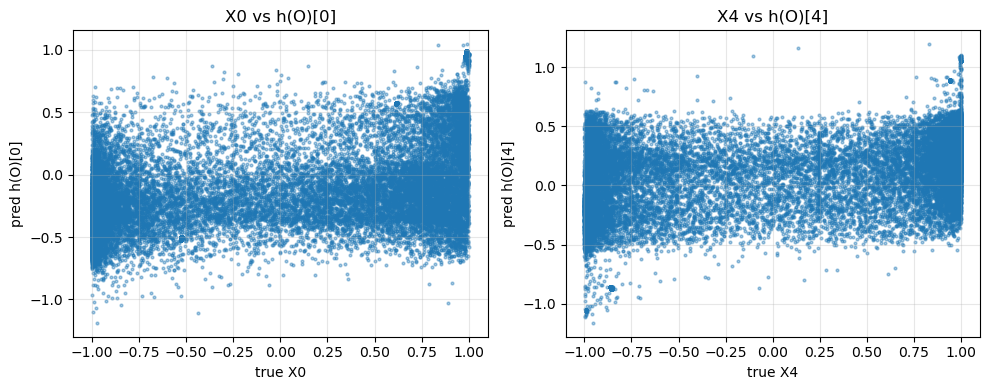

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1) Build dataset: O -> X from expert full_records
# -------------------------------------------------------
O_list = []
X_list = []

for r in full_records:
    obs = r['obs']
    if 'O' not in obs or 'X' not in obs:
        continue
    if len(obs['O']) == 0 or len(obs['X']) == 0:
        continue

    O_t = np.asarray(obs['O'][-1], dtype=np.float32)   # (4,)
    X_t = np.asarray(obs['X'][-1], dtype=np.float32)   # (8,)

    O_list.append(O_t)
    X_list.append(X_t)

O_arr = np.stack(O_list, axis=0)   # (N, 4)
X_arr = np.stack(X_list, axis=0)   # (N, 8)

print("Dataset sizes:", O_arr.shape, X_arr.shape)

# train/val split
O_train, O_val, X_train, X_val = train_test_split(
    O_arr, X_arr, test_size=0.2, random_state=0
)

O_train_t = torch.from_numpy(O_train).to(device)
X_train_t = torch.from_numpy(X_train).to(device)
O_val_t   = torch.from_numpy(O_val).to(device)
X_val_t   = torch.from_numpy(X_val).to(device)

# -------------------------------------------------------
# 2) Define small network h: R^4 -> R^8
# -------------------------------------------------------
class OrientationToActionNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 8)
        )

    def forward(self, o):
        return self.net(o)

h_net = OrientationToActionNet(hidden_dim=128).to(device)
optimizer = optim.Adam(h_net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# -------------------------------------------------------
# 3) Train
# -------------------------------------------------------
batch_size = 256
num_epochs = 50

def iterate_minibatches(O, X, batch_size):
    N = O.shape[0]
    idx = np.random.permutation(N)
    for start in range(0, N, batch_size):
        end = start + batch_size
        b_idx = idx[start:end]
        yield O[b_idx], X[b_idx]

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    h_net.train()
    epoch_loss = 0.0
    for O_b, X_b in iterate_minibatches(O_train_t, X_train_t, batch_size):
        optimizer.zero_grad()
        pred = h_net(O_b)
        loss = criterion(pred, X_b)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * O_b.size(0)
    epoch_loss /= O_train_t.size(0)
    train_losses.append(epoch_loss)

    # validation
    h_net.eval()
    with torch.no_grad():
        pred_val = h_net(O_val_t)
        val_loss = criterion(pred_val, X_val_t).item()
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | train MSE: {epoch_loss:.4f} | val MSE: {val_loss:.4f}")

# -------------------------------------------------------
# 4) Inspect quality: per-dimension correlation X vs h(O)
# -------------------------------------------------------
h_net.eval()
with torch.no_grad():
    X_pred = h_net(torch.from_numpy(O_arr).to(device)).cpu().numpy()

corrs = []
for i in range(8):
    xi = X_arr[:, i]
    pi = X_pred[:, i]
    c = np.corrcoef(xi, pi)[0, 1]
    corrs.append(c)

print("Per-dimension corr(X_i, h(O)_i):")
for i, c in enumerate(corrs):
    print(f"  dim {i}: {c:.3f}")

# Optional: plot true vs predicted for a couple of action dims
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, i in zip(axes, [0, 4]):  # e.g., plot dims 0 and 4
    ax.scatter(X_arr[:, i], X_pred[:, i], s=4, alpha=0.4)
    ax.set_xlabel(f"true X{i}")
    ax.set_ylabel(f"pred h(O)[{i}]")
    ax.set_title(f"X{i} vs h(O)[{i}]")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()